# Setting the scene

You are a team of young graduates and you want to create your own fintech company. You know that Crystal Dawn Private Qants has been trying for years to develop an effective portfolio management strategy. 

Unfortunately, an epidemic of *Lukehead Byus* struck their analysts before they could deliver their solution. Armed with this information, you don't pass up the opportunity to sell them your own strategy.

Your Crystal Dawn spy, who miraculously escaped the epidemic, has managed to get you an interview for next Friday. 

He provides you with the company's requirements, which must be met or you'll have no chance of winning the contract:

- The portfolio should always comprise between 80 and 120 stocks.
- You may only invest in the 304 representative S&P 500 stocks supplied with this notebook.
- The strategy must be 'blind'; it is forbidden to use implicit information linked to the future when rolling your strategy on historical data. (You risk catching *Luckehead Byus*.)
- You can rebalance your portfolio daily.
- You can harvest additional data from yfinance or other financial data services to calculate additional factors or enrich your models.
- The creativity and realism of your solutions will be highly appreciated during the evaluation.


The company you're trying to sell your strategy to will be holding mini-conferences on Saturday morning and Sunday. Make sure to attend to gather additional information on what they'll be looking for in your presentation.

Note: *Withdrawing completely during a period is allowed ($\sum w_i=0$) if the withdrawal signal is algorithmically generated and not the consequence of an arbitrary decision. Beware of Luckehead Byus!

## Deliverables
To pass the preliminary interview you must provide:
- A notebook written in Python or functional R with some mandatory code cells.
- A submission.csv file containing the weighting of your portfolio (the amount invested in each stock) over the period 2000-2015 in a format corresponding to the `sample_submission.csv` file. 

If you pass the preliminary interview, you'll need to prepare a quick 6-minute pitch to convince your potential client of the quality of your strategy. Crystal Dawn Private Quants asks you to present your strategy in the following format:

- Slide 1: intuition, methodological process (data, efforts to avoid overfitting, optimization constraints, and objective function)
- Slide 2: summary table of various metrics, value-added curves, worst-case drawdowns, sector allocation
- Slide 3: value-added performance calendar
- Slide 4: recent portfolio view (number of stocks, overweight, underweight...)

You'll find out on Tuesday evening whether you've passed this preliminary interview and are selected for the final interview.

In [1]:
#!pip install pandas seaborn matplotlib numpy statsmodels scikit-learn tqdm


In [2]:
import pandas as pd 
import numpy as np 
import sklearn as sk
import matplotlib.pyplot as plt
from tqdm import tqdm


## Loading data

In [3]:
ROOT='./kaggle/input/dt23-test/'


In [4]:
adjusted_close = pd.read_csv(ROOT+'series/adjusted_close.csv',index_col=0)
adjusted_close.index = pd.to_datetime(adjusted_close.index)
# Uncomment the following line to test the notebook on a reduced number of 
# products that span the entire makespan
# adjusted_close = adjusted_close.dropna(axis=1).iloc[:,:20]

adjusted_close.head()


,adjusted_close_CSCO,adjusted_close_ISRG,adjusted_close_TPR,adjusted_close_DVN,adjusted_close_MRO,adjusted_close_BA,adjusted_close_GILD,adjusted_close_MDT,adjusted_close_V,adjusted_close_A,...,adjusted_close_CI,adjusted_close_BALL,adjusted_close_JNJ,adjusted_close_DOV,adjusted_close_CRM,adjusted_close_PGR,adjusted_close_WAT,adjusted_close_BWA,adjusted_close_BLK,adjusted_close_PPL
timestamp,,,,,,,,,,,,,,,,,,,,,
2023-10-06,53.450000,295.68,28.19,43.70,24.59,187.38,74.74,76.12,235.04,110.64,...,288.23,46.13,157.64,138.89,207.36,142.860000,267.40,39.88,648.26,23.44
2023-10-05,53.070000,290.09,27.58,42.85,24.24,186.29,74.70,76.15,233.48,110.35,...,285.35,47.72,157.14,138.31,202.01,142.500000,265.99,38.66,640.30,22.96
2023-10-04,53.450000,290.28,27.84,43.35,24.40,186.73,74.74,76.27,231.22,111.67,...,285.08,49.27,155.52,137.92,201.87,142.160000,267.76,39.22,636.53,22.91
2023-10-03,53.650000,288.04,27.95,45.75,25.68,188.92,73.27,76.54,228.81,110.26,...,284.41,48.73,155.34,137.78,199.83,139.302010,265.01,38.87,625.47,22.98
2023-10-02,53.997474,294.98,28.58,45.65,25.59,187.83,74.10,77.77,231.27,110.90,...,287.54,49.26,155.15,137.68,203.71,138.872313,270.52,39.86,643.04,22.55


 ## Portfolio weighting
Enter here the functions you will use to generate your portfolio weights based on indicators taken from historical data or produced with statistical and/or machine learning methods.

**Make sure that the relationship $\sum_{i=1}^{i=302}w_i=1$ is always respected.

**Beware of NaNs in the dataset, as they correspond to times when certain products are either no longer or not yet available**.

The methods you see here are not valid for the final submission:
 - `rand_weights`: randomly selects 5 titles and generates random weights.
 - `best_return_fibo`: selects the 10 best stocks based on a prediction of their return and assigns them weights proportional to the first 10 terms of the Fibonacci sequence.
 - `equal_weights`: produces a uniformly balanced portfolio, replicating the benchmark

In [5]:
def rand_weights(returns,*args,**kwargs):
    """
        Produces random weights for num_to_select assets 
    """
    # The following array will be True for all products i that are available
    product_availability_mask = ~returns.iloc[-1].isna().values
    
    # The following array will contain all the indices i of available products
    available_product_indices = np.nonzero(product_availability_mask)[0]
    
    weights = np.zeros(len(returns.T))
    num_to_select = 125
    
    # Generate unique random indices within the array size
    random_indices = np.random.choice(available_product_indices, num_to_select, replace=False)

    # Create a boolean mask based on the randomly selected indices
    mask = np.zeros(len(weights), dtype=bool)
    mask[random_indices] = True
    rw = np.random.rand(sum(mask))
    rw /= sum(rw)
    weights[mask]=rw
    return pd.Series({"weight_"+a.split('_')[-1]:b for a,b in zip(returns.columns,weights)})

def best_returns_fibo(returns,*args,**kwargs):
    """ 
        Selects the 10 best returns and assigns weights according to a fibonacci ratio 
    """
    weights = np.zeros(len(returns.T))

    # Select the indices of the 10 best stocks
    indices=np.argsort(returns.iloc[-1].values)[::-1]
    indices=indices[~np.isnan(returns.values[0][indices])][:10]

    # Generate weights according to a fibonacci sequence
    fibo = np.array([1, 1, 2, 3, 5, 8, 13, 21, 34, 55])[::-1].astype(float)
    fibo /= sum(fibo)

    # Create a boolean mask based on the randomly selected indices
    mask = np.zeros(len(weights), dtype=bool)
    mask[indices] = True
    
    weights[mask]=fibo
    return pd.Series({"weight_"+a.split('_')[-1]:b for a,b in zip(returns.columns,weights)})

def equal_weights(returns,*args,**kwargs):
    """
        Produces an equally weighted portfolio
        this is how the benchmark is generated
    """
    weights = np.zeros(len(returns.T))
    indices = np.arange(len(weights))[~np.isnan(returns.values[0])]
    weights[indices] = 1/len(indices)
    return pd.Series({"weight_"+a.split('_')[-1]:b for a,b in zip(returns.columns,weights)})
    

## Predictive model
Program your predictive and analytical models here, which will enable you to choose the best possible weighting given the data prior to the rebalancing.

This is where you have to be careful not to catch the *Lukehead Byus*: you're taking big risks if the arguments of your functions take into account data subsequent to the moment of rebalancing ('knowing' a priori that AAPL will perform well constitutes posterior data). 

The current model is very simplistic:
- `polynomial_regression`: performs a simple regression with a 3rd degree polynomial to try to predict how each stock will perform the next day.

In [6]:
import statsmodels.api as sm
from sklearn.preprocessing import PolynomialFeatures

def polynomial_regression(past_prices):
    """
        Fits a 3d degree polynomial for each asset and returns the predicted value
    """

    models={}

    # Fitting a 3d degree polynomial for each asset
    for c in past_prices.columns:
        x=past_prices[[c]]
        xp = PolynomialFeatures(degree=3).fit_transform(np.arange(len(x)).reshape((len(x),1)))
        model = sm.OLS(x.values, xp).fit()
        models[c] = model

    # Returning the expected return for the next timestep for all stocks
    return pd.DataFrame({k:v.predict(PolynomialFeatures(degree=3).fit_transform(np.array([len(x)]).reshape((1,1)))) for k,v in models.items()})/past_prices.iloc[-1]


## Daily reset

This is where you choose what to supply to the previously implemented functions.

The use of `rolling()` ([documentation](https://pandas.pydata.org/docs/reference/api/pandas.DataFrame.rolling.html)) is practically mandatory to avoid incorporating future data into your system.

If you do not respect the `2019-10-31`-`2023-09-01` interval, your solution will not be accepted. 

In [7]:
# This cell might be running for longer than the others, 
# try to reduce the makespan or the complexity of your computations for speeding it up
# Keep in mind that a year on the stock market is 252 days
weights_df = []
index = []
adjusted_close=adjusted_close.sort_index()
rolling_start = pd.to_datetime('1999-01-01') # Observation period starts maximum 1 year before the strategy starts (trailing_window_size<=252)
start,stop = pd.to_datetime('2000-01-01'),pd.to_datetime('2015-01-01')

trailing_window_size = 30
stock_prices = adjusted_close[(adjusted_close.index>=pd.to_datetime(rolling_start))&(adjusted_close.index<pd.to_datetime(stop))]

for x in tqdm(stock_prices.rolling(trailing_window_size)):

    # If the trailing window is the right size and the current date is after the start date
    if len(x)==trailing_window_size and x.index.max()>=start:

        index.append(x.index.max())
        weights = rand_weights(polynomial_regression(x))
        
        # The following line checks that you do not invest in unavailable positions
        assert (weights.values[np.where(x.iloc[-1].isna())]!=0.0).sum()==0
        
        weights_df.append(weights)


0it [00:00, ?it/s]

3816it [12:37,  5.04it/s]


#### Generate submission in required format.
**Make sure to properly sort the dates and add an `id` column**

In [8]:
weights_df = pd.DataFrame(weights_df,index=index)
weights_df[weights_df.index>=start].sort_index().reset_index(names='date').to_csv('submission.csv',index_label='id')


## Evaluation

The following cells must be present and functional in the notebook you supply, otherwise you will be disqualified.

In [9]:
weights_df = pd.read_csv('submission.csv',index_col=1)
weights_df.drop(columns=['id'],inplace=True)
weights_df.index = pd.to_datetime(weights_df.index)
prices_df = adjusted_close.loc[weights_df.index]
returns_df = prices_df.shift(-1)/prices_df


### Graphs

In [10]:
bmrk = pd.read_csv(ROOT+'series/benchmark/benchmark_returns.csv',index_col=0)
bmrk.index = pd.to_datetime(bmrk.index)


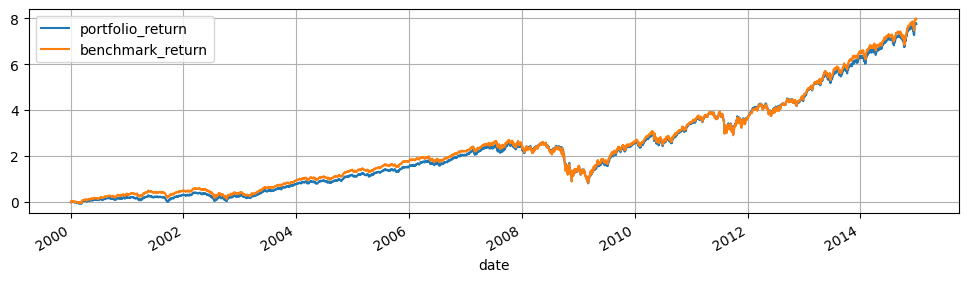

In [11]:
portfolio_performance = pd.DataFrame(pd.DataFrame(returns_df.values*weights_df.values, columns=weights_df.columns, index=weights_df.index).sum(axis=1),columns=['portfolio_return'])[:-2]
daily_returns = portfolio_performance.merge(bmrk,left_index=True,right_index=True,how='left')-1
cumulative_returns = ((daily_returns+1).cumprod()-1)
cumulative_returns.plot(figsize=(12,3))
plt.grid()


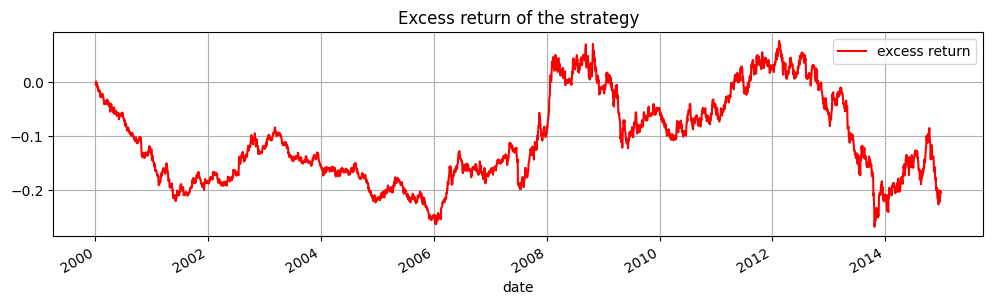

In [12]:
(cumulative_returns['portfolio_return']-cumulative_returns['benchmark_return']).plot(figsize=(12,3),label='excess return',color='r',legend=True)
plt.title('Excess return of the strategy')
plt.grid()


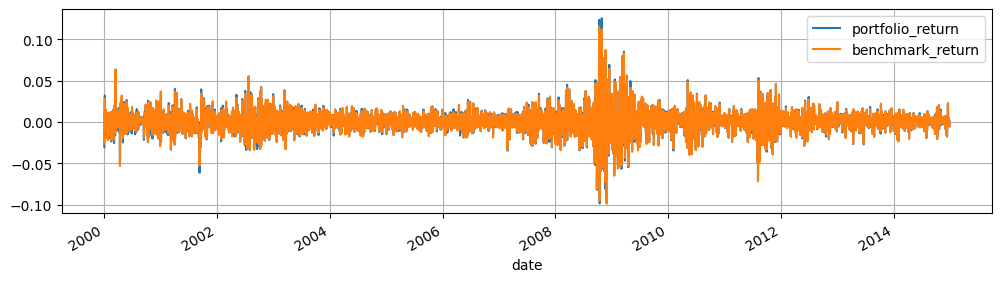

In [13]:
daily_returns.plot(figsize=(12,3))
plt.grid()


### Annualized added value

In [14]:
annualized_return = (1+daily_returns).prod()**(252/len(daily_returns))-1
added_value_annualized = annualized_return['portfolio_return']-annualized_return['benchmark_return']
added_value_annualized


-0.0017829529223143403

### Annualized active risk

In [15]:
excess_return = daily_returns['portfolio_return']-daily_returns['benchmark_return']
active_risk_annualized = excess_return.std()*np.sqrt(252)
active_risk_annualized


0.028365846368824492

### Annualized information ratio
This is the metric used on Kaggle.

In [16]:
information_ratio_annualized = added_value_annualized/active_risk_annualized
information_ratio_annualized


-0.06285562218492081

### Worst relative drawdown

In [17]:
max_seen_so_far = cumulative_returns.cummax()
drawdown = (cumulative_returns-max_seen_so_far)/max_seen_so_far
worst_drawdown = drawdown.min()
relative_worst_drawdown = worst_drawdown['portfolio_return']-worst_drawdown['benchmark_return']
relative_worst_drawdown


-1.8399640909369483

### Average number of stocks

In [18]:
average_number_of_stocks = (weights_df>0).sum(axis=1).mean()
average_number_of_stocks


125.0

### Annual turnover rate

In [19]:
turnover_annual = (weights_df.diff().abs().sum(axis=1)/2).mean()*252
turnover_annual


179.2885954394956

## Sanity check
These cells allow you to check if your solution complies with the constraints mentioned in the statement above.

In [20]:
for i,x in enumerate(weights_df.values):

    # Checks you respect the long-only and the cardinality constraint 
    n_positions = sum(x>.0000001)
    assert n_positions==0 or n_positions>=120

    # Checks you do not invest in non existing stocks
    assert (x[np.where(adjusted_close.loc[weights_df.index[i]].isna())]!=0.0).sum()==0
        